In [14]:
# Import required packages/modules
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import sample
import math
from itertools import chain
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from sklearn.utils import shuffle

In [15]:
# Set working directory and import csv
# os.chdir("C:/Users/LynchZ20/Desktop/Courses/MSDS/SY_S2/ML/FinalProject/COVID19_DeepLearning/")
dd = pd.read_csv("final.csv")

In [20]:
# Look at summary info
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80843 entries, 0 to 80842
Data columns (total 16 columns):
date                                 80843 non-null object
fips                                 80843 non-null object
cases                                80843 non-null int64
deaths                               80843 non-null int64
type                                 70959 non-null object
total_population                     80843 non-null float64
population_density_per_sqmi          80843 non-null float64
percent_adults_with_obesity          80843 non-null float64
food_environment_index               80447 non-null float64
income_ratio                         80804 non-null float64
median_household_income              80843 non-null float64
percent_65_and_over                  80843 non-null float64
percent_less_than_18_years_of_age    80843 non-null float64
percent_non_hispanic_white           80843 non-null float64
life_expectancy                      80843 non-null float6

In [19]:
# Fill in missing values for life_expectancy
lifexp_med = np.median(dd.query("life_expectancy.notnull()", engine='python')['life_expectancy'])
dd.loc[np.isnan(dd["life_expectancy"]), "life_expectancy"] = lifexp_med

In [21]:
# Initialize dataframe and number of days to keep for RNN
trend_df = pd.DataFrame(columns={"cases_trend","deaths_trend", "demographic_inputs","SAH"})
trend_list = []
days_in_sequence = 20
reverse = True

# Churn through each county and create a row for each day with the previous 14 days of data
for county in dd.fips.unique():
    county_df = dd.query(f"fips=='{county}'")
            
    # Make strides of 1, and ignore padding on both ends at this point
    for i in range(0,len(county_df)):
        if i+days_in_sequence<=len(county_df):

            if reverse: # Grab the next X days for the model if we are reversing
                #Prepare list of cases and deaths
                cases_trend = [float(x) for x in county_df[-i-days_in_sequence:-1-i].cases.values]
                deaths_trend = [float(x) for x in county_df[-i-days_in_sequence:-1-i].deaths.values]

                #Add response value
                SAH = float(county_df.iloc[-i-days_in_sequence].SAH)

                #preparing all the demographic inputs
                total_population = float(county_df.iloc[-i-days_in_sequence].total_population)
                density = float(county_df.iloc[-i-days_in_sequence].population_density_per_sqmi)
                percent_adults_with_obesity = float(county_df.iloc[-i-days_in_sequence].percent_adults_with_obesity)
                median_household_income = float(county_df.iloc[-i-days_in_sequence].median_household_income)
                percent_65_and_over = float(county_df.iloc[-i-days_in_sequence].percent_65_and_over)
                percent_less_than_18_years_of_age = float(county_df.iloc[-i-days_in_sequence].percent_less_than_18_years_of_age)
                percent_non_hispanic_white = float(county_df.iloc[-i-days_in_sequence].percent_non_hispanic_white)
                life_expectancy = float(county_df.iloc[-i-days_in_sequence].life_expectancy)

            else:
                cases_trend = [float(x) for x in county_df[i:i+days_in_sequence-1].cases.values]
                deaths_trend = [float(x) for x in county_df[i:i+days_in_sequence-1].deaths.values]

                #Add response value
                SAH = float(county_df.iloc[i+days_in_sequence-1].SAH)

                #preparing all the demographic inputs
                total_population = float(county_df.iloc[i+days_in_sequence-1].total_population)
                density = float(county_df.iloc[i+days_in_sequence-1].population_density_per_sqmi)
                percent_adults_with_obesity = float(county_df.iloc[i+days_in_sequence-1].percent_adults_with_obesity)
                median_household_income = float(county_df.iloc[i+days_in_sequence-1].median_household_income)
                percent_65_and_over = float(county_df.iloc[i+days_in_sequence-1].percent_65_and_over)
                percent_less_than_18_years_of_age = float(county_df.iloc[i+days_in_sequence-1].percent_less_than_18_years_of_age)
                percent_non_hispanic_white = float(county_df.iloc[i+days_in_sequence-1].percent_non_hispanic_white)
                life_expectancy = float(county_df.iloc[i+days_in_sequence-1].life_expectancy)


            trend_list.append({
                                "cases_trend":np.asarray(cases_trend),
                                "deaths_trend":np.asarray(deaths_trend),
                                "demographic_inputs":[total_population,density,percent_adults_with_obesity,median_household_income,percent_65_and_over,percent_less_than_18_years_of_age,percent_non_hispanic_white,life_expectancy],
                                "SAH":SAH})

trend_df = pd.DataFrame(trend_list)

# Capture demographic size and temporal size
dem_input_size = len(trend_df['demographic_inputs'][0])
temp_input_size = trend_df.drop(axis=1, columns = ['SAH', 'demographic_inputs'], inplace=False).shape[1]

In [22]:
# Prepare RNN input
trend_df["inputs"] = [np.asarray([trends["cases_trend"],trends["deaths_trend"]]) for idx,trends in trend_df.iterrows()]
trend_df = shuffle(trend_df)

In [23]:
# Set up train/test split
sequence_length = days_in_sequence - 1
training_percentage = 0.7

# Perform train/test split
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [24]:
# Prepare train sets
X_temporal_train = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in training_df["inputs"].values]),(training_item_count,2,sequence_length)),(0,2,1) )).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_train = np.asarray([np.asarray(x) for x in training_df["SAH"]]).astype(np.float32)

# Prepare test sets
X_temporal_test = np.asarray(np.transpose(np.reshape(np.asarray([np.asarray(x) for x in validation_df["inputs"].values]),(validation_item_count,2,sequence_length)),(0,2,1) )).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_test = np.asarray([np.asarray(x) for x in validation_df["SAH"]]).astype(np.float32)

In [25]:
#temporal input branch
temporal_input_layer = Input(shape=(sequence_length,temp_input_size))
main_rnn_layer = layers.LSTM(64, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
demographic_input_layer = Input(shape=(dem_input_size))
demographic_dense = layers.Dense(16)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.2)(demographic_dense)

#cases output branch
rnn_c = layers.LSTM(32)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dropout])
dense_c = layers.Dense(128)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation='sigmoid')(dropout_c)

# Build model
model = Model([temporal_input_layer,demographic_input_layer], cases)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 19, 2)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 19, 64)       17152       input_3[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 16)           144         input_4[0][0]                    
____________________________________________________________________________________________

In [26]:
callbacks = [ReduceLROnPlateau(monitor='loss', patience=4, verbose=1, factor=0.6),
             EarlyStopping(monitor='loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='loss', save_best_only=True)]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit([X_temporal_train,X_demographic_train], Y_train, 
          epochs = 10, 
          batch_size = 25, 
          validation_data=([X_temporal_test,X_demographic_test],  Y_test),
          callbacks=callbacks
          )

Train on 21566 samples, validate on 9243 samples
Epoch 1/10
18175/21566 [========================>.....] - ETA: 4s - loss: nan - accuracy: 0.5880

KeyboardInterrupt: 

In [25]:
sum(Y_test)/len(Y_test)

0.40133073677377473

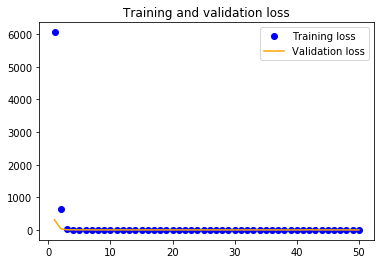

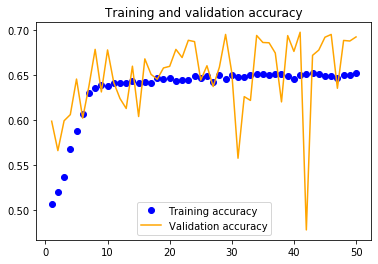

In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [ ]:
# Generate predictions
model.load_weights("best_model.h5")
predictions = model.predict([X_temporal_test,X_demographic_test])